In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import mae, mse, binary_crossentropy
from keras.optimizers import Adam, Adadelta, Adagrad, SGD
from keras.models import Model

Using TensorFlow backend.


In [3]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

## seed
np.random.seed(1)
tf.set_random_seed(2)

In [4]:
def Conv3D_model(input_shape):
    input_layer = Input(input_shape)
    prev_layer = input_layer
    for i in range(5):
        conv_layer1 = Conv3D(filters=(i+1)*8, kernel_size=(3, 3, 3))(prev_layer)
        conv_layer1 = Activation('relu')(conv_layer1)
        conv_layer2 = Conv3D(filters=(i+1)*8, kernel_size=(3, 3, 3))(conv_layer1)
        conv_layer2 = BatchNormalization()(conv_layer2)
        conv_layer2 = Activation('relu')(conv_layer2)
        pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
        prev_layer = pooling_layer2

#     flatten_layer = Dropout(0.5)(prev_layer)
#     flatten_layer = Flatten()(flatten_layer)
    
    flatten_layer = Flatten()(prev_layer)
    
    age_layer = Dense(units=1, activation='linear' , name='age')(flatten_layer)
    sex_layer = Dense(units=1, activation='sigmoid', name='sex')(flatten_layer)
    
    return Model(inputs=input_layer, outputs=[age_layer, sex_layer])

In [5]:
# Handle missing labels, mask for empty value
mask_value = -1
def masked_mae(y_true, y_pred):
    mask = k.cast(k.not_equal(y_true, mask_value), k.floatx())
    return mae(y_true * mask, y_pred * mask)

def masked_mse(y_true, y_pred):
    mask = k.cast(k.not_equal(y_true, mask_value), k.floatx())
    return mse(y_true * mask, y_pred * mask)

def masked_binary_crossentropy(y_true, y_pred):
    mask = k.cast(k.not_equal(y_true, mask_value), k.floatx())
    return binary_crossentropy(y_true * mask, y_pred * mask)

In [6]:
class DataGen:
    
    def __init__(self, csv,  directory):
        df = pd.read_csv(os.path.join(directory, csv))
        self.dir = directory
        self.filename = np.array(df['file'])
        
        # missing values should be -1
        self.age      = np.array(df['age'])
        
        self.sex = -np.ones(len(df))
        self.sex[df['sex'] == 'm'] = 0
        self.sex[df['sex'] == 'f'] = 1
        
        one_brain = np.array(nib.load( os.path.join(self.dir, self.filename[0]) ).get_data())
        self.shape = one_brain.shape
        self.dtype = one_brain.dtype
        self.total_samples = len(self.filename)
        
        self.next_index = 0
        self.init()
        
        
    def init(self):
        rand_indicies = np.random.permutation(np.arange(len(self.filename)))
        self.filename = self.filename[rand_indicies]
        self.age = self.age[rand_indicies]
        self.sex = self.sex[rand_indicies]
        self.next_index = 0
        
    def samples_left(self):
        return self.total_samples - self.next_index
        
    def getBatch(self, n_samples):
        n_samples_left = self.samples_left()
        assert n_samples_left>0, "No samples left, call dataGen.init()"
        
        n_samples = n_samples if n_samples_left>n_samples else n_samples_left
        data = np.empty((n_samples,)+self.shape+(1,), self.dtype)
        age_label = np.empty(n_samples, self.dtype)
        sex_label = np.empty(n_samples, self.dtype)
        # should spawn a thread to load data
        for i in range(n_samples):
            data[i,:,:,:,0] = np.array(nib.load(os.path.join(self.dir, self.filename[self.next_index])).get_data())
            age_label[i] = self.age[self.next_index]
            sex_label[i] = self.sex[self.next_index]
            self.next_index = self.next_index+1
        
        return data, [age_label, sex_label]
    
    # generator for keras fit_generator function
    def generator(self, batch_size, num_batches_to_load):
        # using a batch_size such that i*batch_size = dataset_size
        #assert self.total_samples%batch_size == 0, "Batch_size should be a divisor of DataGen.total_sample"
        num_batches = self.total_samples//batch_size
        #assert num_batches%num_batches_to_load==0, "num_batches_to_load should be a divisor of num_batches"
        num_loads = num_batches//num_batches_to_load
        while True:
            self.init()
            for load in range(num_loads):
                X, y = self.getBatch(num_batches_to_load*batch_size)
                age,sex = y
                for index in range(num_batches_to_load):
                    yield (X[index*batch_size:(index+1)*batch_size], [age[index*batch_size:(index+1)*batch_size], sex[index*batch_size:(index+1)*batch_size]])


In [7]:
def kerasPlot(history):
    plt.subplot(3, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 3)
    plt.title('Age')
    plt.plot(history.history['age_loss'])
    plt.plot(history.history['val_age_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 4)
    plt.title('Sex')
    plt.plot(history.history['sex_loss'])
    plt.plot(history.history['val_sex_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 5)
    plt.plot(history.history['age_mean_absolute_error'])
    plt.plot(history.history['val_age_mean_absolute_error'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 6)
    plt.plot(history.history['sex_acc'])
    plt.plot(history.history['val_sex_acc'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

In [8]:
dg = DataGen('train.csv', './data')
dg_val = DataGen('validation.csv', './data')
print("Training Samples:", dg.total_samples, ",  Validation Samples:", dg_val.total_samples,)

Training Samples: 918 ,  Validation Samples: 100


In [9]:
model = Conv3D_model(dg.shape+(1,))
batch_size = 5
load_size = 30 # how many batches should be in ram
epochs = 200
metrics={'age':'mae', 'sex':'accuracy'}
model.compile(loss={'age':masked_mae, 'sex':masked_binary_crossentropy}, optimizer='Adam', metrics=metrics)
# Adagrad prone to overfitting for some reason

In [10]:
dg_val.init()
val_data = dg_val.getBatch(dg_val.total_samples)
history = model.fit_generator(dg.generator(batch_size, load_size),
                                      steps_per_epoch =  np.ceil(dg.total_samples/batch_size),
                                      epochs = epochs,
                                      validation_data=val_data,
                                      verbose=1)

Epoch 1/200
184/184 [==============================] - 283s 2s/step - loss: 12.3920 - age_loss: 11.7119 - sex_loss: 0.6801 - age_mean_absolute_error: 25.5553 - sex_acc: 0.6022 - val_loss: 11.1170 - val_age_loss: 10.3660 - val_sex_loss: 0.7510 - val_age_mean_absolute_error: 22.7658 - val_sex_acc: 0.4900
Epoch 2/200
184/184 [==============================] - 247s 1s/step - loss: 8.1712 - age_loss: 7.5580 - sex_loss: 0.6132 - age_mean_absolute_error: 31.7044 - sex_acc: 0.6707 - val_loss: 7.1170 - val_age_loss: 6.5112 - val_sex_loss: 0.6058 - val_age_mean_absolute_error: 30.4334 - val_sex_acc: 0.6900
Epoch 3/200
184/184 [==============================] - 247s 1s/step - loss: 6.9791 - age_loss: 6.4003 - sex_loss: 0.5788 - age_mean_absolute_error: 33.1907 - sex_acc: 0.6935 - val_loss: 9.8227 - val_age_loss: 9.1896 - val_sex_loss: 0.6331 - val_age_mean_absolute_error: 24.7119 - val_sex_acc: 0.5900
Epoch 4/200
184/184 [==============================] - 248s 1s/step - loss: 7.0033 - age_loss: 6

184/184 [==============================] - 247s 1s/step - loss: 2.0661 - age_loss: 1.8976 - sex_loss: 0.1685 - age_mean_absolute_error: 32.3407 - sex_acc: 0.9370 - val_loss: 4.2022 - val_age_loss: 3.7810 - val_sex_loss: 0.4211 - val_age_mean_absolute_error: 31.1130 - val_sex_acc: 0.8100
Epoch 29/200
184/184 [==============================] - 242s 1s/step - loss: 2.0390 - age_loss: 1.8836 - sex_loss: 0.1554 - age_mean_absolute_error: 31.7402 - sex_acc: 0.9511 - val_loss: 5.0447 - val_age_loss: 4.5840 - val_sex_loss: 0.4607 - val_age_mean_absolute_error: 35.0118 - val_sex_acc: 0.7800
Epoch 30/200
184/184 [==============================] - 241s 1s/step - loss: 1.9441 - age_loss: 1.8237 - sex_loss: 0.1204 - age_mean_absolute_error: 32.3921 - sex_acc: 0.9630 - val_loss: 4.7156 - val_age_loss: 4.2353 - val_sex_loss: 0.4803 - val_age_mean_absolute_error: 30.4523 - val_sex_acc: 0.8200
Epoch 31/200
184/184 [==============================] - 250s 1s/step - loss: 1.7501 - age_loss: 1.6225 - sex_l

184/184 [==============================] - 247s 1s/step - loss: 1.3012 - age_loss: 1.2531 - sex_loss: 0.0481 - age_mean_absolute_error: 32.1065 - sex_acc: 0.9870 - val_loss: 4.7409 - val_age_loss: 4.3360 - val_sex_loss: 0.4049 - val_age_mean_absolute_error: 36.5972 - val_sex_acc: 0.8600
Epoch 56/200
184/184 [==============================] - 247s 1s/step - loss: 1.1757 - age_loss: 1.1446 - sex_loss: 0.0311 - age_mean_absolute_error: 31.4909 - sex_acc: 0.9957 - val_loss: 4.4314 - val_age_loss: 3.9223 - val_sex_loss: 0.5091 - val_age_mean_absolute_error: 34.5004 - val_sex_acc: 0.8400
Epoch 57/200
184/184 [==============================] - 247s 1s/step - loss: 1.2109 - age_loss: 1.1864 - sex_loss: 0.0246 - age_mean_absolute_error: 31.3976 - sex_acc: 0.9946 - val_loss: 4.5165 - val_age_loss: 3.9108 - val_sex_loss: 0.6057 - val_age_mean_absolute_error: 31.7658 - val_sex_acc: 0.7900
Epoch 58/200
184/184 [==============================] - 247s 1s/step - loss: 1.2785 - age_loss: 1.2499 - sex_l

184/184 [==============================] - 241s 1s/step - loss: 1.0093 - age_loss: 0.9957 - sex_loss: 0.0135 - age_mean_absolute_error: 32.0650 - sex_acc: 0.9989 - val_loss: 4.4381 - val_age_loss: 3.9032 - val_sex_loss: 0.5349 - val_age_mean_absolute_error: 33.4685 - val_sex_acc: 0.8300
Epoch 83/200
184/184 [==============================] - 250s 1s/step - loss: 1.0885 - age_loss: 1.0779 - sex_loss: 0.0107 - age_mean_absolute_error: 30.9954 - sex_acc: 0.9989 - val_loss: 4.5302 - val_age_loss: 4.0641 - val_sex_loss: 0.4661 - val_age_mean_absolute_error: 35.5925 - val_sex_acc: 0.8400
Epoch 84/200
184/184 [==============================] - 247s 1s/step - loss: 0.9879 - age_loss: 0.9744 - sex_loss: 0.0135 - age_mean_absolute_error: 32.0576 - sex_acc: 0.9989 - val_loss: 5.1552 - val_age_loss: 4.6042 - val_sex_loss: 0.5510 - val_age_mean_absolute_error: 30.7354 - val_sex_acc: 0.8100
Epoch 85/200
184/184 [==============================] - 247s 1s/step - loss: 1.0461 - age_loss: 1.0357 - sex_l

184/184 [==============================] - 248s 1s/step - loss: 0.9331 - age_loss: 0.9150 - sex_loss: 0.0180 - age_mean_absolute_error: 32.6952 - sex_acc: 0.9924 - val_loss: 5.0411 - val_age_loss: 4.1988 - val_sex_loss: 0.8423 - val_age_mean_absolute_error: 33.0379 - val_sex_acc: 0.7500
Epoch 110/200
184/184 [==============================] - 248s 1s/step - loss: 0.8660 - age_loss: 0.8558 - sex_loss: 0.0102 - age_mean_absolute_error: 32.0088 - sex_acc: 0.9978 - val_loss: 4.8292 - val_age_loss: 4.0058 - val_sex_loss: 0.8234 - val_age_mean_absolute_error: 32.2249 - val_sex_acc: 0.7600
Epoch 111/200
184/184 [==============================] - 242s 1s/step - loss: 0.8903 - age_loss: 0.8809 - sex_loss: 0.0094 - age_mean_absolute_error: 30.3388 - sex_acc: 0.9978 - val_loss: 4.6899 - val_age_loss: 4.0506 - val_sex_loss: 0.6393 - val_age_mean_absolute_error: 32.5537 - val_sex_acc: 0.8000
Epoch 112/200
184/184 [==============================] - 242s 1s/step - loss: 0.7955 - age_loss: 0.7894 - se

184/184 [==============================] - 250s 1s/step - loss: 0.7722 - age_loss: 0.7689 - sex_loss: 0.0034 - age_mean_absolute_error: 32.1344 - sex_acc: 1.0000 - val_loss: 4.7058 - val_age_loss: 4.1966 - val_sex_loss: 0.5092 - val_age_mean_absolute_error: 31.9526 - val_sex_acc: 0.8400
Epoch 137/200
184/184 [==============================] - 247s 1s/step - loss: 0.7881 - age_loss: 0.7842 - sex_loss: 0.0039 - age_mean_absolute_error: 31.6097 - sex_acc: 1.0000 - val_loss: 4.4056 - val_age_loss: 3.8964 - val_sex_loss: 0.5092 - val_age_mean_absolute_error: 33.3070 - val_sex_acc: 0.8800
Epoch 138/200
184/184 [==============================] - 247s 1s/step - loss: 0.8013 - age_loss: 0.7917 - sex_loss: 0.0096 - age_mean_absolute_error: 31.2119 - sex_acc: 0.9978 - val_loss: 5.1241 - val_age_loss: 4.3184 - val_sex_loss: 0.8058 - val_age_mean_absolute_error: 34.3615 - val_sex_acc: 0.8200
Epoch 139/200
184/184 [==============================] - 247s 1s/step - loss: 0.7480 - age_loss: 0.7357 - se

184/184 [==============================] - 257s 1s/step - loss: 0.6493 - age_loss: 0.6422 - sex_loss: 0.0071 - age_mean_absolute_error: 31.7215 - sex_acc: 0.9978 - val_loss: 4.4829 - val_age_loss: 3.8462 - val_sex_loss: 0.6367 - val_age_mean_absolute_error: 32.6205 - val_sex_acc: 0.8200
Epoch 164/200
184/184 [==============================] - 258s 1s/step - loss: 0.7361 - age_loss: 0.7325 - sex_loss: 0.0036 - age_mean_absolute_error: 30.6096 - sex_acc: 1.0000 - val_loss: 4.7865 - val_age_loss: 3.9292 - val_sex_loss: 0.8572 - val_age_mean_absolute_error: 35.2311 - val_sex_acc: 0.8200
Epoch 165/200
184/184 [==============================] - 244s 1s/step - loss: 0.6900 - age_loss: 0.6820 - sex_loss: 0.0080 - age_mean_absolute_error: 32.4836 - sex_acc: 0.9989 - val_loss: 4.5991 - val_age_loss: 4.0518 - val_sex_loss: 0.5473 - val_age_mean_absolute_error: 32.2870 - val_sex_acc: 0.8600
Epoch 166/200
184/184 [==============================] - 251s 1s/step - loss: 0.7595 - age_loss: 0.7562 - se

184/184 [==============================] - 247s 1s/step - loss: 0.6055 - age_loss: 0.6034 - sex_loss: 0.0021 - age_mean_absolute_error: 31.9337 - sex_acc: 1.0000 - val_loss: 4.4433 - val_age_loss: 3.8262 - val_sex_loss: 0.6171 - val_age_mean_absolute_error: 33.4549 - val_sex_acc: 0.8500
Epoch 191/200
184/184 [==============================] - 248s 1s/step - loss: 0.6228 - age_loss: 0.6210 - sex_loss: 0.0018 - age_mean_absolute_error: 31.9668 - sex_acc: 1.0000 - val_loss: 4.6524 - val_age_loss: 3.9963 - val_sex_loss: 0.6561 - val_age_mean_absolute_error: 30.8218 - val_sex_acc: 0.8200
Epoch 192/200
184/184 [==============================] - 248s 1s/step - loss: 0.6733 - age_loss: 0.6715 - sex_loss: 0.0019 - age_mean_absolute_error: 31.2137 - sex_acc: 1.0000 - val_loss: 4.7324 - val_age_loss: 4.0619 - val_sex_loss: 0.6705 - val_age_mean_absolute_error: 34.1844 - val_sex_acc: 0.8600
Epoch 193/200
184/184 [==============================] - 248s 1s/step - loss: 0.6725 - age_loss: 0.6709 - se

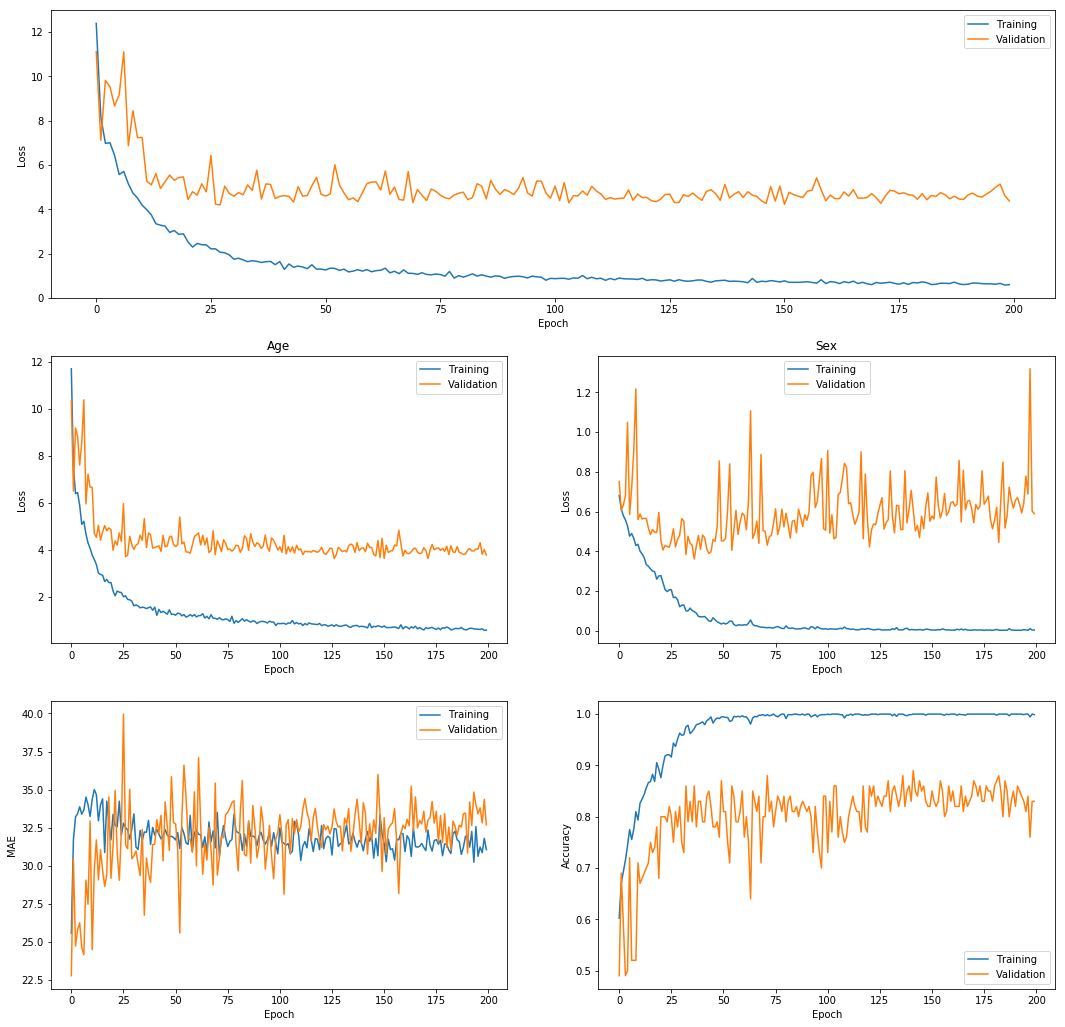

In [11]:
plt.rcParams['figure.figsize'] = [18, 18]
kerasPlot(history)

In [12]:
from sklearn.metrics import accuracy_score, mean_absolute_error
IXI_val = DataGen('IXI_val.csv', './data')
OASIS_val = DataGen('OASIS3_val.csv', './data')

IXI_val_data = IXI_val.getBatch(IXI_val.total_samples)
OASIS_val_data = OASIS_val.getBatch(OASIS_val.total_samples)

In [14]:
X,y = IXI_val_data
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)

In [24]:
print("IXI age mean absolute error:",mean_absolute_error(age, age_hat))
print("IXI sex validation accuracy:",accuracy_score(sex,sex_hat>.5))

IXI age mean absolute error: 7.578764
IXI sex validation accuracy: 0.76


In [26]:
X,y = OASIS_val_data
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
np.all(age==-1)

True

In [27]:
print("OASIS sex validation accuracy:",accuracy_score(sex,sex_hat>.5))

OASIS sex validation accuracy: 0.9


In [28]:
#import dill
#dill.dump_session('age_sex_trained.db')

In [ ]:
#dill.load_session('age_sex_trained.db')